In [1]:
import scipy.io as sio
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy.fft import fft, ifft, fftfreq 
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
import xgboost as xgb
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from scipy.signal import blackman
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
def load_data(path):
    y = []
    arrays=[]
    for filename in os.listdir(path):
        arrays.append(sio.loadmat(os.path.join(path,filename))["a"])
        ind = filename[3]
        if ind == "H":
            y.append(0)
        elif ind == "F":
            y.append(1)
        elif ind == "M":
            y.append(2)
    X = np.stack(arrays,axis=0)
    #X= np.squeeze(X)
    y = np.asarray(y)
    X,y = shuffle(X,y)
    return X,y
            

In [3]:
X_train, y_train = load_data("data/train")
X_val, y_val = load_data("data/val")
X_test,y_test = load_data("data/test")

In [4]:
print(f"X_train shape:{X_train.shape} y_train shape:{y_train.shape}")
print(f"X_val shape:{X_val.shape} y_val shape:{y_val.shape}")
print(f"X_test shape:{X_test.shape} y_test shape:{y_test.shape}")

X_train shape:(36, 24577, 1) y_train shape:(36,)
X_val shape:(6, 24577, 1) y_val shape:(6,)
X_test shape:(18, 24577, 1) y_test shape:(18,)


In [5]:
def reshuffle(X_train, X_val, y_train,y_val, train_size=36, val_size=6):
    X = np.concatenate((X_train, X_val,))
    y = np.concatenate((y_train, y_val,))
    X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=train_size, stratify=y)
    return X_train, X_val, y_train, y_val
    

In [6]:
def combine(X_train, X_val, y_train, y_val):
    X = np.concatenate((X_train, X_val,))
    y = np.concatenate((y_train, y_val,))
    return X, y

In [7]:
def split_up(x,y, factor=6):
    x_new = []
    y_new = []
    series_dim = x.shape[1]
    for i, series in enumerate(x):
        for n in range(0, factor):
            #print(x_new)
            x_tmp =series[n*series_dim//factor:(n+1)*series_dim//factor]
            x_tmp = np.squeeze(x_tmp)
            x_new.append(x_tmp)
            y_new.append(y[i])
    x_new = np.asarray(x_new)
    y_new = np.asarray(y_new)
    return x_new, y_new
        

In [8]:
X_train_split, y_train_split = split_up(X_train[:,1:], y_train, factor=3)
X_val_split, y_val_split = split_up(X_val[:,1:], y_val, factor=3)
X_test_split, y_test_split = split_up(X_test[:,1:], y_test, factor=3)


In [9]:
print(f"X_train_split shape:{X_train_split.shape} y_train_split shape:{y_train_split.shape}")
print(f"X_val_split shape:{X_val_split.shape} y_val_split shape:{y_val_split.shape}")
print(f"X_test_split shape:{X_test_split.shape} y_test_split shape:{y_test_split.shape}")

X_train_split shape:(108, 8192) y_train_split shape:(108,)
X_val_split shape:(18, 8192) y_val_split shape:(18,)
X_test_split shape:(54, 8192) y_test_split shape:(54,)


In [10]:
zeros = np.where(y_train_split==0)[0]
ones = np.where(y_train_split==1)[0]
twos = np.where(y_train_split==2)[0]

In [11]:
zer = np.random.choice(zeros)
one = np.random.choice(ones)
two = np.random.choice(twos)

In [50]:
y_split

array([2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2])

(0.0, 2.0)

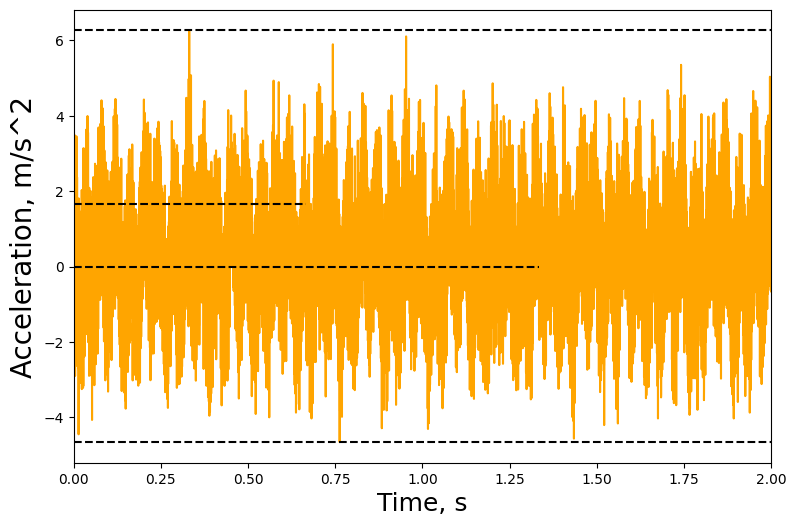

In [94]:
fig, ax = plt.subplots(figsize=(9,6), dpi=100)
ax.plot(np.linspace(0,2, 2*4096),X_split[30], color='orange')
ax.axhline(0, color='k', linestyle='--', xmax=0.667)
ax.axhline(rms(X_split[30]), color='k', linestyle='--', xmax=0.333)
ax.axhline(np.max(X_split[30]), color='k', linestyle='--')
ax.axhline(np.min(X_split[30]), color='k', linestyle='--')
ax.set_xlabel('Time, s', fontsize=18)
ax.set_ylabel('Acceleration, m/s^2', fontsize=20)
ax.set_xlim(0,2)
#right_side = ax.spines["right"]
#right_side.set_visible(False) 

In [13]:
t = np.zeros(8192, dtype=np.complex128)
t[48] = fft(X_train_split[zer])[48]
t[8144] = fft(X_train_split[zer])[8144]

In [14]:
daikts = np.real(ifft(t)) #im parts are very small, probably computational error

In [15]:
t = np.zeros(8192, dtype=np.complex128)
t[1200] = fft(X_train_split[zer])[1200]
t[6992] = fft(X_train_split[zer])[6992]
gmf = np.real(ifft(t))

In [16]:
t = np.zeros(8192, dtype=np.complex128)
t[2400] = fft(X_train_split[zer])[2400]
t[5792] = fft(X_train_split[zer])[5792]
gmf_2 = np.real(ifft(t))

In [17]:
t = np.zeros(8192, dtype=np.complex128)
t[16] = fft(X_train_split[zer])[16]
t[8176] = fft(X_train_split[zer])[8176]
fan = np.real(ifft(t))

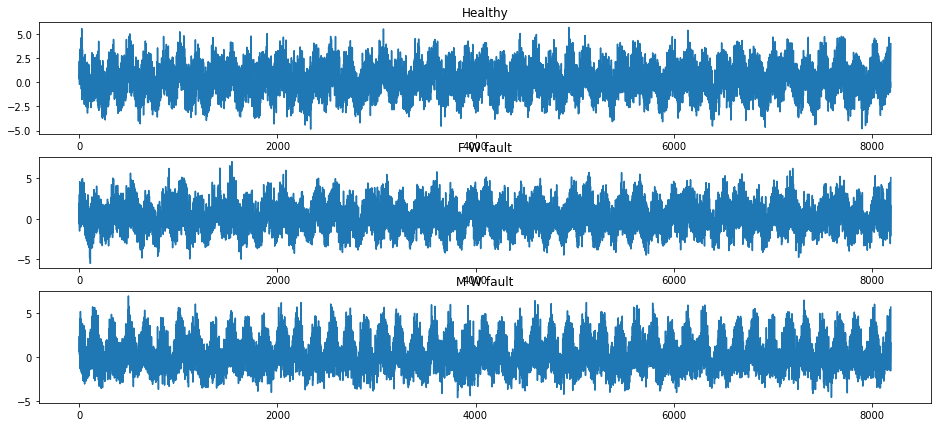

In [18]:

fig, ax = plt.subplots(3,1, figsize=(16,7))
N = 2**6
ind = np.random.rand()
x = np.linspace(0.0, len(X_train_split[zer]), len(X_train_split[zer]), endpoint=False)

ax[0].set_title("Healthy")
ax[1].set_title("F W fault")
ax[2].set_title("M W fault")
ax[0].plot(x,X_train_split[zer])

#ax[0].plot(x,daikts)#np.sin(6.28*24*x/4096+2.5)) #NEVEIKS PO RESTARTO NES FFT DARAU VELIAU IR BUS NAUJAS SAMPLE
#ax[0].plot(x,daikts+gmf)
#ax[0].plot(x,daikts+gmf+gmf_2)
ax[1].plot(x,X_train_split[one])
ax[2].plot(x,X_train_split[two])

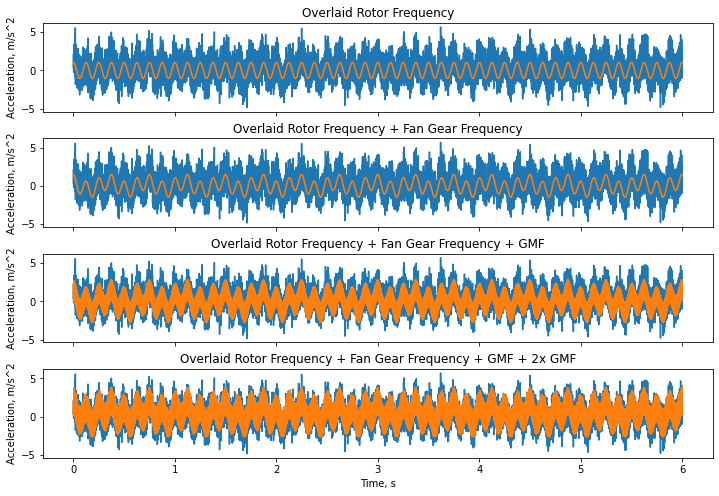

In [19]:
fig, ax = plt.subplots(4, figsize=(12,8), sharex=True)
x = np.linspace(0.0, 6, len(X_train_split[zer]), endpoint=False)

ax[0].set_title("Overlaid Rotor Frequency")

ax[0].set_ylabel("Acceleration, m/s^2")
ax[0].plot(x,X_train_split[zer])
ax[0].plot(x,daikts)
ax[1].set_title("Overlaid Rotor Frequency + Fan Gear Frequency")
ax[1].set_ylabel("Acceleration, m/s^2")
ax[1].plot(x,X_train_split[zer])
ax[1].plot(x,daikts + fan)
ax[2].set_title("Overlaid Rotor Frequency + Fan Gear Frequency + GMF")
ax[2].set_ylabel("Acceleration, m/s^2")
ax[2].plot(x,X_train_split[zer])
ax[2].plot(x,daikts +fan + gmf) #NEVEIKS PO RESTARTO NES FFT DARAU VELIAU IR BUS NAUJAS SAMPLE
ax[3].set_title("Overlaid Rotor Frequency + Fan Gear Frequency + GMF + 2x GMF")
ax[3].set_ylabel("Acceleration, m/s^2")
ax[3].plot(x,X_train_split[zer])
ax[3].plot(x,daikts +fan + gmf + gmf_2)
ax[3].set_xlabel("Time, s")
plt.subplots_adjust(#left=0.1,
                    #bottom=0.2, 
                    #right=0.9, 
                    #top=0.9, 
                    hspace=0.3
)

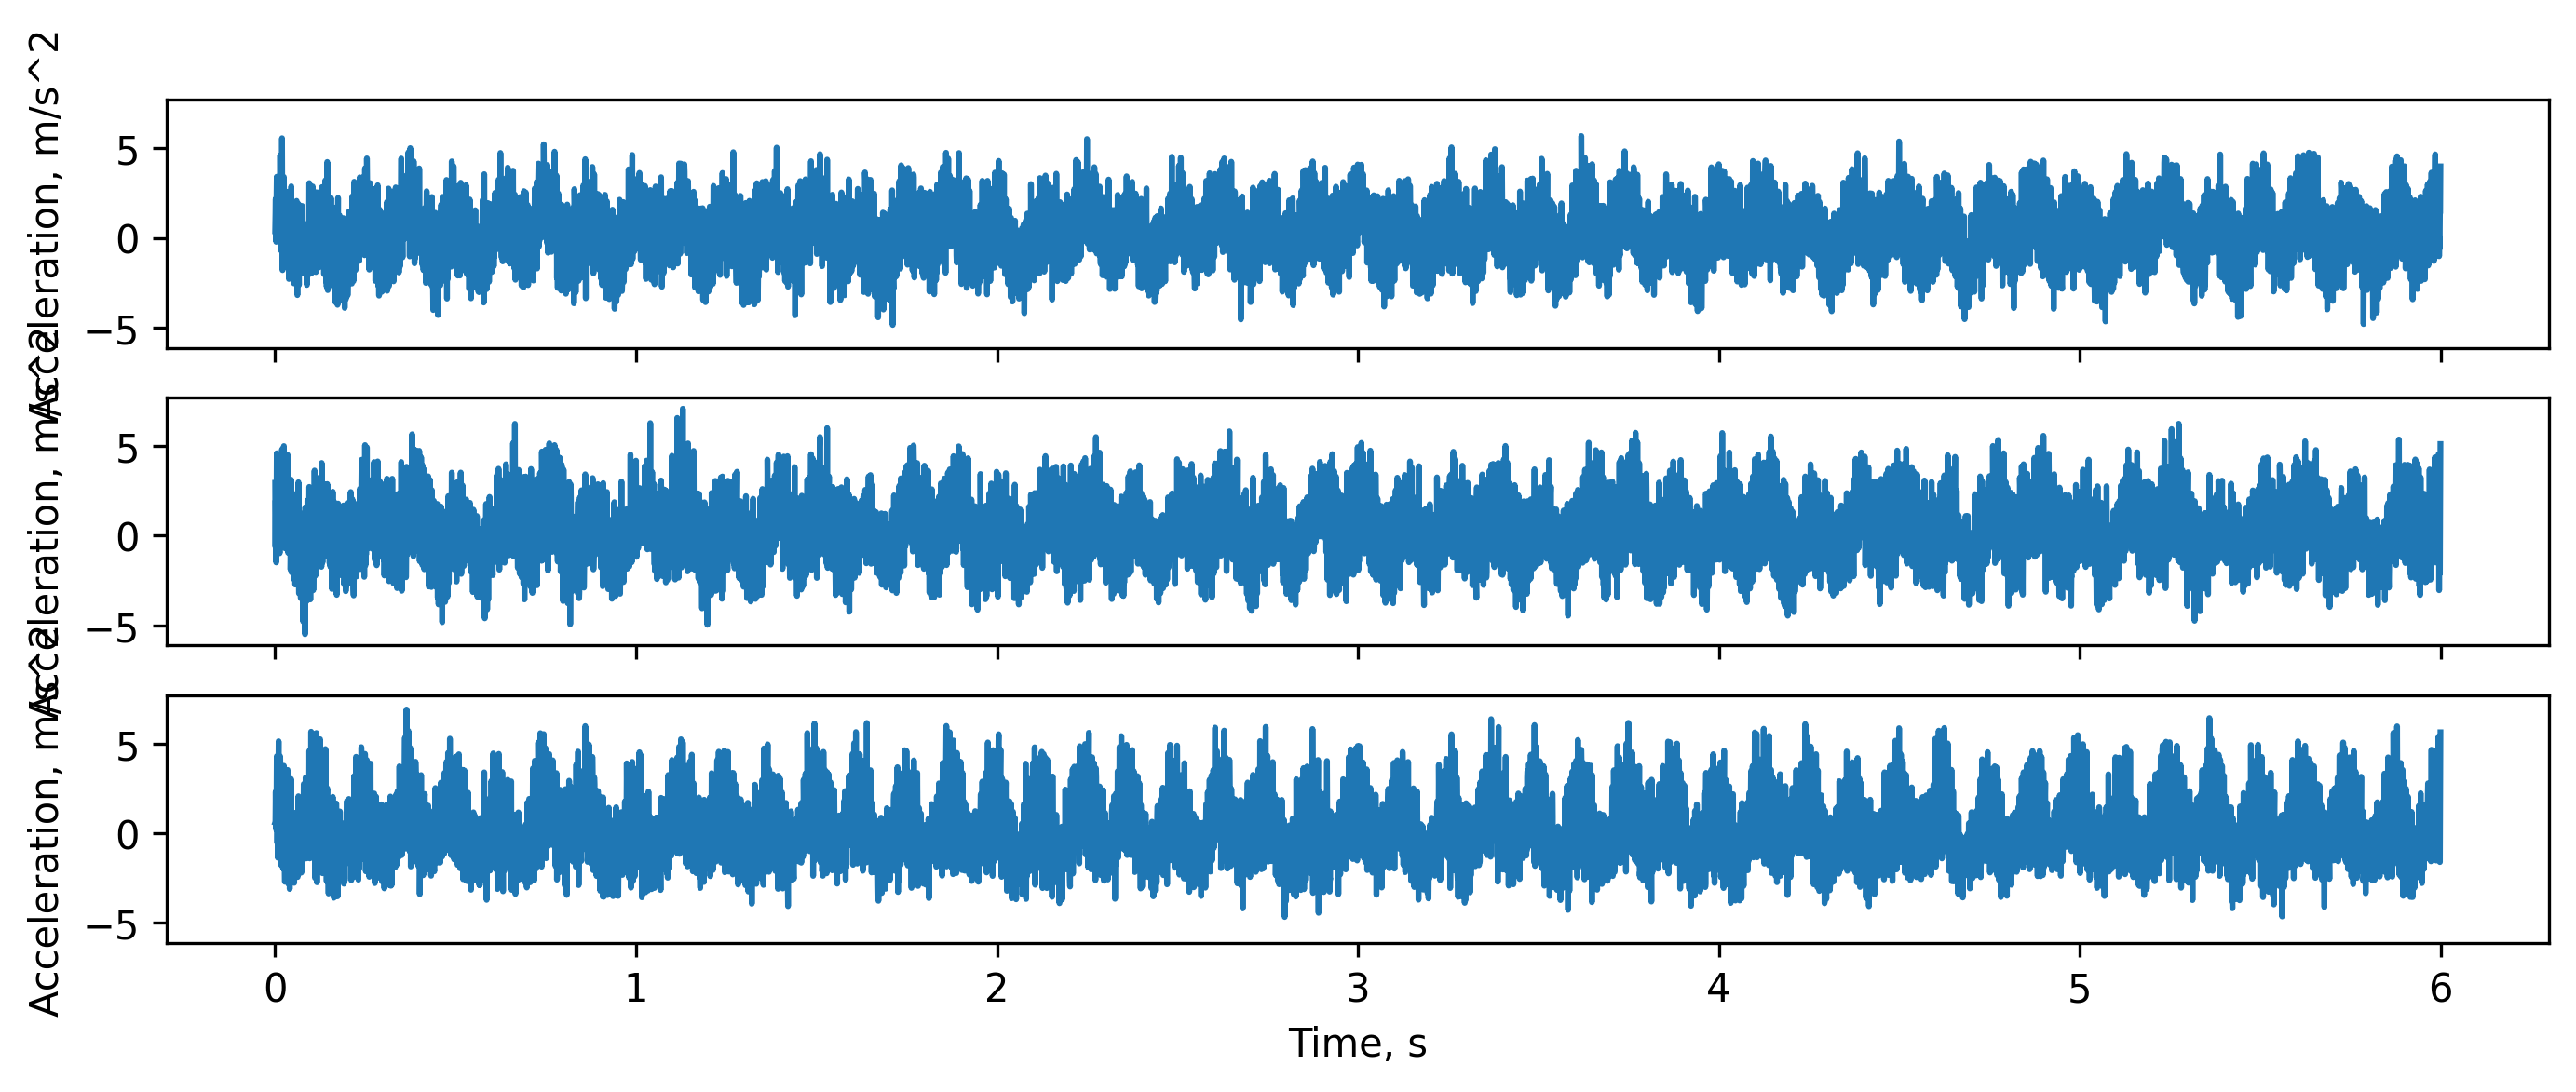

In [243]:
fig, ax = plt.subplots(3, sharex=True, sharey=True, dpi=300)
x = np.linspace(0.0, 6, len(X_train_split[zer]), endpoint=False)
ax[0].plot(x,X_train_split[zer])
ax[0].set_ylabel("Acceleration, m/s^2")
#ax[1].set_xlabel("Time, s")
ax[1].plot(x,X_train_split[one])
ax[1].set_ylabel("Acceleration, m/s^2")
ax[2].set_xlabel("Time, s")
ax[2].plot(x,X_train_split[two])
ax[2].set_ylabel("Acceleration, m/s^2")
fig = plt.gcf()
fig.set_size_inches(11, 4)


In [22]:
def fft_transform(X, samples=400, T=1/4096):
    N = samples
    x = np.linspace(0.0, N*T, N, endpoint=False)
    yf = fft(X)
    xf = fftfreq(N, T)[:N//2]
    amps = 2.0/N * np.abs(yf[0:N//2])
    amps = np.squeeze(amps)
    return (xf, amps)
    

In [258]:
s =2*4096
X_train_fft = [fft_transform(i, samples=s) for i in X_train_split]
X_val_fft = [fft_transform(i, samples=s) for i in X_val_split]
X_test_fft = [fft_transform(i, samples=s) for i in X_test_split]

In [246]:
fig, axs = plt.subplots(3,1, figsize=(10,9), sharex = True, dpi=1000)
for i in range(1):
    
    #zer = np.random.choice(zeros)
    #one = np.random.choice(ones)
    #two = np.random.choice(twos)
    max_points = 8
    max_h = sorted((X_train_fft[zer][1]))[-4:]
    max_p = sorted(X_train_fft[one][1])[-max_points:]
    max_f = sorted(X_train_fft[two][1])[-max_points:]
    h_locs = np.array([np.where(X_train_fft[zer][1] ==i)[0][0] for i in max_h])
    p_locs = np.array([np.where(X_train_fft[one][1] ==i)[0][0] for i in max_p])
    f_locs = np.array([np.where(X_train_fft[two][1] ==i)[0][0] for i in max_f])
    axs[0].plot(X_train_fft[zer][0], X_train_fft[zer][1])
    abs_diff = abs(X_train_fft[one][1] - X_train_fft[zer][1])
    abs_diff[np.where(abs_diff<0.08)] = 0
    
    abs_diff_2 = abs(X_train_fft[two][1] - X_train_fft[zer][1])
    abs_diff_2[np.where(abs_diff_2<0.08)] = 0
    #axs[1].plot(X_train_fft[one][0],abs_diff,c="#52047a"  , linewidth=2)
    #axs[1].plot(X_train_fft[one][0], abs_diff_2,c="darkturquoise" , linewidth=2)
    axs[1].plot(X_train_fft[one][0], X_train_fft[one][1], #c="#eebf04"
               )
    axs[2].plot(X_train_fft[two][0], X_train_fft[two][1])
    
    h_adj = [h_loc -1 for h_loc in h_locs]
    p_adj =[p_loc -1 for p_loc in p_locs]
    f_adj = [f_loc -1 for f_loc in f_locs]
    
    axs[0].scatter(X_train_fft[zer][0][h_adj]-.5, X_train_fft[zer][1][h_locs], c="r", s=5)
    axs[1].scatter(X_train_fft[one][0][p_adj]-.5, X_train_fft[one][1][p_locs], c="r",s = 5)
    axs[2].scatter(X_train_fft[two][0][f_adj]-.5, X_train_fft[two][1][f_locs], c="r", s=5)
    for l,k in enumerate(max_h):
        
        value = "{:.2f}".format(k)
        x_ =X_train_fft[two][0][h_locs][l]
        text = value + f" ({X_train_fft[two][0][h_locs][l]:.2f})"
        #axs[0].annotate(text, (X_train_fft[zer][0][h_locs][l], X_train_fft[zer][1][h_locs][l]))
        
    for l,k in enumerate(max_p):
        value = "{:.2f}".format(k)
        text = value + f" ({X_train_fft[two][0][p_locs][l]:.2f})"
        #axs[1].annotate(text, (X_train_fft[one][0][p_locs][l], X_train_fft[one][1][p_locs][l]))
        
    for l,k in enumerate(max_f):
        value = "{:.2f}".format(k)
        text = value + f" ({X_train_fft[two][0][f_locs][l]:.2f})"
        #axs[2].annotate(text, (X_train_fft[two][0][f_locs][l], X_train_fft[two][1][f_locs][l]))
        
    axs[0].set_title("Healthy Gearbox", fontdict={'fontsize': 13, 'fontweight': 'medium'})
    #axs[0].titlesize=100
    axs[1].set_title("Fan Wheel Fault", fontdict={'fontsize': 13, 'fontweight': 'medium'})
    #axs[1].spines['top'].set_visible(False)
    axs[2].set_title("Pinion Wheel Fault", fontdict={'fontsize': 13, 'fontweight': 'medium'})
    axs[0].set_xlim(0,1250)
    axs[1].set_xlim(0,1250)
    axs[2].set_xlim(0,1250)
    #axs[2].set_ylim(0,1.3)
    axs[0].set_ylabel("Acceleration, m/s^2")
    axs[1].set_ylabel("Acceleration, m/s^2")
    axs[2].set_ylabel("Acceleration, m/s^2")
    axs[2].set_xlabel("Frequency, Hz")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    hspace=0.2)

In [29]:
ohe = OneHotEncoder(sparse=False)
SS = StandardScaler()

In [30]:
ohe.fit(y_train_split.reshape(-1,1))

OneHotEncoder(sparse=False)

In [31]:
dt = DecisionTreeClassifier()
svm = SVC()
rf = RandomForestClassifier()

In [32]:
X_train_input = np.array([i[1] for i in X_train_fft])
y_train_input = ohe.transform(y_train_split.reshape(-1,1))
X_val_input=np.array([i[1] for i in X_val_fft])
y_val_input = ohe.transform(y_val_split.reshape(-1,1))
X_test_input=np.array([i[1] for i in X_test_fft])
y_test_input = ohe.transform(y_test.reshape(-1,1))

In [33]:
X,y = combine(X_train, X_val, y_train, y_val)
X_split, y_split = split_up(X[:,1:], y, factor=3) 
s =2*4096
X_fft = [fft_transform(i, samples=s) for i in X_split]
X_input = np.array([i[1] for i in X_fft])
y_input = ohe.transform(y_split.reshape(-1,1))

In [33]:
rf_params = {"max_depth":[2,3,4,5,6,7,8,9], "n_estimators":[5,20,40,70,100,150,250]}
dt_params = {"max_depth":[2,3,4,5,6,7,8,9,10,11]}
svm_params = {"C":np.logspace(-6,6, num=20), "kernel": ["poly", "rbf", "linear"], "degree":[2,3,4,5]}
dt_clf = GridSearchCV(dt, dt_params)
svm_clf = GridSearchCV(svm, svm_params)
rf_clf = GridSearchCV(rf, rf_params)
dt_search = dt_clf.fit(X_input, y_split)
print(1)
svm_search = svm_clf.fit(X_input, y_split)
print(2)
rf_search = rf_clf.fit(X_input, y_split)

1


KeyboardInterrupt: 

In [34]:
svm_search.best_estimator_

NameError: name 'svm_search' is not defined

In [271]:
dt_search.best_estimator_

DecisionTreeClassifier(max_depth=3)

In [272]:
rf_search.best_estimator_

RandomForestClassifier(max_depth=8, n_estimators=5)

In [ ]:
pred = svm_search.best_estimator_.predict(SS.transform(X_test_input))

In [ ]:
accuracy_score(pred, y_test_split)

In [ ]:
clf.fit(X_input ,y_split)

In [ ]:
y_train_split

In [ ]:
y_pred = clf.predict(X_train_input)
confusion_matrix(y_train_split,y_pred)

In [ ]:
y_pred = clf.predict(X_val_input)
confusion_matrix(y_val_split,y_pred)

In [ ]:
y_pred = clf.predict(X_test_input)
confusion_matrix(y_test_split,y_pred)

In [ ]:
model = tf.keras.models.Sequential([
    #tf.keras.layers.Dense(3),
    tf.keras.layers.Dense(3, activation="softmax", 
                          kernel_regularizer=tf.keras.regularizers.L1(0.01),
    activity_regularizer=tf.keras.regularizers.L2(0.01))
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss="categorical_crossentropy", metrics="accuracy")


In [ ]:
while True:
    a = model.fit(X_train_input, y_train_input, validation_data=(X_val_input, y_val_input))
    if a.history["accuracy"][0] == 1:
        break

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
scores =[]
preds = []
for train, test in kfold.split(X_input, y_input):
    model = tf.keras.models.Sequential([
    #tf.keras.layers.Dense(3),
    tf.keras.layers.Dense(3, activation="softmax", 
                          kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01,l2=0.01),
    activity_regularizer=tf.keras.regularizers.L1L2
                          (l1=0.01, l2=0.01),
    bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01,l2=0.01),)
    
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss="categorical_crossentropy", metrics="accuracy")
    while True:
        a = model.fit(X_input[train], y_input[train])
        if a.history["accuracy"][0] == 1:
            break
    loss, acc = model.evaluate(X_input[test], y_input[test])
    scores.append(acc)
    if acc == 1:
        best_model = model
scores

In [71]:
best_model.evaluate(X_test_input, y_test_input)

NameError: name 'best_model' is not defined

In [72]:
model.evaluate(X_test_input, y_test_input)

NameError: name 'model' is not defined

In [73]:
model.evaluate(X_val_input, y_val_input)

NameError: name 'model' is not defined

In [35]:
def rms(X):
    return np.sqrt(np.mean(X**2))

In [36]:
def peak(X):
    return (np.max(X) - np.min(X)) /2

In [37]:
def crest(X):
    return peak(X) / rms(X)

In [38]:
from scipy.stats import kurtosis

In [39]:
def impulse_factor(X):
    return peak(X) / np.mean(np.abs(X))

In [40]:
def shape_factor(X):
    return rms(X) / np.mean(np.abs(X))

In [41]:
def t_domain_features(X):
    return [rms(X), 
            peak(X), 
            crest(X), 
            kurtosis(X),
            impulse_factor(X), 
            shape_factor(X)
           ]

In [181]:
X_train_t = [t_domain_features(i) for i in X_train_split]
X_val_t= [t_domain_features(i) for i in X_val_split]
X_test_t = [t_domain_features(i) for i in X_test_split]

In [182]:
X_train_t = np.array(X_train_t)
X_val_t = np.array(X_val_t)
X_test_t = np.array(X_test_t)

In [188]:
#clf = DecisionTreeClassifier(max_depth=4)
#clf = RandomForestClassifier(max_depth=None, n_estimators=100)
clf = SVC(C=10000000,kernel="linear", degree=3)

In [214]:
X_test_t = [t_domain_features(i) for i in np.squeeze(X_test)]
X_test_t = np.array(X_test_t)

In [496]:
X,y = combine(X_train, X_val, y_train, y_val)

X_split, y_split = split_up(X[:,1:], y, factor=3) 
s =2*4096
X_t = [t_domain_features(i) for i in np.squeeze(X)]
X_t = np.array(X_t)
X_test_t = [t_domain_features(i) for i in np.squeeze(X_test)]
X_test_t = np.array(X_test_t)
#X_t = SS.fit_transform(X_t)
y_input = ohe.fit_transform(y.reshape(-1,1))


In [502]:
rf_params = {"max_depth":[2,3,4,5,6,7,8,9, None], "n_estimators":[5,20,70,150,250, 1000]}
dt_params = {"max_depth":[2,3,4,5,6,7,8,9,10,11, None]}
svm_params = {"C":np.logspace(-6,6, num=10), "kernel": ["poly", "rbf", "linear"], "degree":[2,3,4,5]}
dt_clf = GridSearchCV(dt, dt_params)
svm_clf = GridSearchCV(svm, svm_params)
rf_clf = GridSearchCV(rf, rf_params)
#dt_search = dt_clf.fit(X_t, y)
#svm_search = svm_clf.fit(X_t, y)
rf_search = rf_clf.fit(X_t, y)

In [318]:
dt_search.best_score_

1.0

In [319]:
svm_search.best_score_

1.0

In [503]:
rf_search.best_score_

1.0

In [371]:
svm_search.best_estimator_


SVC(C=1e-06, kernel='poly')

In [504]:
rf_search.best_estimator_

RandomForestClassifier(max_depth=4, n_estimators=70)

In [65]:
rf_search.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=1000)

In [66]:
model = tf.keras.models.Sequential([
    #tf.keras.layers.Dense(3),
    tf.keras.layers.Dense(3, activation="softmax", 
                          kernel_regularizer=tf.keras.regularizers.L1(0.001),
    activity_regularizer=tf.keras.regularizers.L2(0.001)
                         )
])

In [67]:

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss="categorical_crossentropy", metrics="accuracy")


c:\users\adam\desktop\crime predictor\part based prototype\env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [362]:
while True:
    model = tf.keras.models.Sequential([
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation="relu"),
    #tf.keras.layers.Dense(30, activation="relu"),
    #tf.keras.layers.Dense(10, activation="relu"),
    #tf.keras.layers.Dense(6, activation="relu"),
    #tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax", 
                        #use_bias=False,
                          #kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01,l2=0.01),
    #activity_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))
                         )
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss="categorical_crossentropy", metrics="accuracy")
              
    a = model.fit(X_t, y_input, epochs = 10)
    if a.history["accuracy"][0] == 1:
        break

Epoch 1/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1762 - accuracy: 0.3333
Epoch 2/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1698 - accuracy: 0.3333
Epoch 3/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1637 - accuracy: 0.3333
Epoch 4/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1583 - accuracy: 0.3333
Epoch 5/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1522 - accuracy: 0.3333
Epoch 6/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1459 - accuracy: 0.3333
Epoch 7/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1402 - accuracy: 0.3333
Epoch 8/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1338 - accuracy: 0.3333
Epoch 9/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1278 - accuracy: 0.3333
Epoch 10/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1225 - accuracy: 0.3333
Epoch 1/10
2/2 [=======================

2/2 [==============================] - 0s 2ms/step - loss: 1.2410 - accuracy: 0.3333
Epoch 7/10
2/2 [==============================] - 0s 3ms/step - loss: 1.2373 - accuracy: 0.3333
Epoch 8/10
2/2 [==============================] - 0s 3ms/step - loss: 1.2337 - accuracy: 0.3333
Epoch 9/10
2/2 [==============================] - 0s 2ms/step - loss: 1.2301 - accuracy: 0.3333
Epoch 10/10
2/2 [==============================] - 0s 3ms/step - loss: 1.2267 - accuracy: 0.3333
Epoch 1/10
2/2 [==============================] - 0s 2ms/step - loss: 1.7342 - accuracy: 0.3333
Epoch 2/10
2/2 [==============================] - 0s 2ms/step - loss: 1.7264 - accuracy: 0.3333
Epoch 3/10
2/2 [==============================] - 0s 3ms/step - loss: 1.7191 - accuracy: 0.3333
Epoch 4/10
2/2 [==============================] - 0s 2ms/step - loss: 1.7116 - accuracy: 0.3333
Epoch 5/10
2/2 [==============================] - 0s 2ms/step - loss: 1.7045 - accuracy: 0.3333
Epoch 6/10
2/2 [==============================] - 

2/2 [==============================] - 0s 2ms/step - loss: 1.1545 - accuracy: 0.3333
Epoch 6/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1526 - accuracy: 0.3333
Epoch 7/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1508 - accuracy: 0.3333
Epoch 8/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1492 - accuracy: 0.3333
Epoch 9/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1474 - accuracy: 0.3333
Epoch 10/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1457 - accuracy: 0.3333
Epoch 1/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1356 - accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1337 - accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1320 - accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1303 - accuracy: 0.0000e+00
Epoch 5/10
2/2 [==================

2/2 [==============================] - 0s 3ms/step - loss: 1.0874 - accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 0s 2ms/step - loss: 1.0839 - accuracy: 0.3333
Epoch 5/10
2/2 [==============================] - 0s 3ms/step - loss: 1.0805 - accuracy: 0.3333
Epoch 6/10
2/2 [==============================] - 0s 3ms/step - loss: 1.0773 - accuracy: 0.3333
Epoch 7/10
2/2 [==============================] - 0s 2ms/step - loss: 1.0741 - accuracy: 0.3333
Epoch 8/10
2/2 [==============================] - 0s 2ms/step - loss: 1.0709 - accuracy: 0.3333
Epoch 9/10
2/2 [==============================] - 0s 3ms/step - loss: 1.0676 - accuracy: 0.3333
Epoch 10/10
2/2 [==============================] - 0s 3ms/step - loss: 1.0646 - accuracy: 0.3333
Epoch 1/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1400 - accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1369 - accuracy: 0.3333
Epoch 3/10
2/2 [==========================

2/2 [==============================] - 0s 2ms/step - loss: 1.1253 - accuracy: 0.3333
Epoch 2/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1225 - accuracy: 0.3333
Epoch 3/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1200 - accuracy: 0.3333
Epoch 4/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1173 - accuracy: 0.3333
Epoch 5/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1147 - accuracy: 0.3333
Epoch 6/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1121 - accuracy: 0.3333
Epoch 7/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1094 - accuracy: 0.3333
Epoch 8/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1067 - accuracy: 0.3333
Epoch 9/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1043 - accuracy: 0.3333
Epoch 10/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1016 - accuracy: 0.3333
Epoch 1/10
2/2 [==============================] - 

Epoch 6/10
2/2 [==============================] - 0s 2ms/step - loss: 1.0800 - accuracy: 0.6667
Epoch 7/10
2/2 [==============================] - 0s 3ms/step - loss: 1.0759 - accuracy: 0.6667
Epoch 8/10
2/2 [==============================] - 0s 2ms/step - loss: 1.0716 - accuracy: 0.6667
Epoch 9/10
2/2 [==============================] - 0s 2ms/step - loss: 1.0674 - accuracy: 0.6667
Epoch 10/10
2/2 [==============================] - 0s 2ms/step - loss: 1.0632 - accuracy: 0.6667
Epoch 1/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1889 - accuracy: 0.3333
Epoch 2/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1841 - accuracy: 0.3333
Epoch 3/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1795 - accuracy: 0.3333
Epoch 4/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1748 - accuracy: 0.3333
Epoch 5/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1705 - accuracy: 0.3333
Epoch 6/10
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.9526 - accuracy: 0.6667
Epoch 6/10
2/2 [==============================] - 0s 3ms/step - loss: 0.9499 - accuracy: 0.6667
Epoch 7/10
2/2 [==============================] - 0s 2ms/step - loss: 0.9474 - accuracy: 0.6667
Epoch 8/10
2/2 [==============================] - 0s 2ms/step - loss: 0.9446 - accuracy: 0.6667
Epoch 9/10
2/2 [==============================] - 0s 2ms/step - loss: 0.9421 - accuracy: 0.6667
Epoch 10/10
2/2 [==============================] - 0s 3ms/step - loss: 0.9395 - accuracy: 0.6667
Epoch 1/10
2/2 [==============================] - 0s 2ms/step - loss: 1.5316 - accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 0s 3ms/step - loss: 1.5256 - accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 0s 3ms/step - loss: 1.5193 - accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 0s 3ms/step - loss: 1.5135 - accuracy: 0.0000e+00
Epoch 5/10
2/2 [==================

2/2 [==============================] - 0s 2ms/step - loss: 1.2734 - accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 0s 2ms/step - loss: 1.2695 - accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 0s 2ms/step - loss: 1.2656 - accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 0s 2ms/step - loss: 1.2618 - accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 0s 3ms/step - loss: 1.2581 - accuracy: 0.0000e+00
Epoch 8/10
2/2 [==============================] - 0s 2ms/step - loss: 1.2543 - accuracy: 0.0000e+00
Epoch 9/10
2/2 [==============================] - 0s 2ms/step - loss: 1.2506 - accuracy: 0.0000e+00
Epoch 10/10
2/2 [==============================] - 0s 2ms/step - loss: 1.2468 - accuracy: 0.0000e+00
Epoch 1/10
2/2 [==============================] - 0s 3ms/step - loss: 1.1485 - accuracy: 0.5952
Epoch 2/10
2/2 [==============================] - 0s 2ms/step - loss: 1.1441 - accuracy: 0.3333
Epoch 3/10
2/2 [==

KeyboardInterrupt: 

In [343]:
kfold = StratifiedKFold(n_splits=5, shuffle=False)
scores =[]
b = 0
for train, test in kfold.split(X_t, y):
    model = tf.keras.models.Sequential([
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation="relu"),
    #tf.keras.layers.Dense(5, activation="relu"),
    #tf.keras.layers.Dense(10, activation="relu"),
    #tf.keras.layers.Dense(6, activation="relu"),
    #tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax", 
                        #use_bias=False,
                          #kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01,l2=0.01),
    #activity_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                         )
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss="categorical_crossentropy", metrics="accuracy")
    while True:
        a = model.fit(X_t[train], y_input[train])
        if a.history["accuracy"][0] == 1:
            break
    loss, acc = model.evaluate(X_t[test], y_input[test])
    scores.append(acc)
    if acc == 1:
        best_model = model
    if acc > b:
        b = acc
        best_model = model

c:\users\adam\desktop\crime predictor\part based prototype\env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 0s 2ms/step - loss: 1.0963 - accuracy: 0.3030


2/2 [==============================] - 0s 2ms/step - loss: 0.7778 - accuracy: 0.6970


2/2 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.6667


2/2 [==============================] - 0s 2ms/step - loss: 0.4745 - accuracy: 0.7879


2/2 [==============================] - 0s 3ms/step - loss: 0.3884 - accuracy: 0.8182


2/2 [==============================] - 0s 3ms/step - loss: 0.3057 - accuracy: 0.9697


2/2 [==============================] - 0s 2ms/step - loss: 0.8187 - accuracy: 0.6765


2/2 [==============================] - 0s 3ms/step - loss: 0.5533 - accuracy: 0.6765


2/2 [==============================] - 0s 3ms/step - loss: 0.4803 - accuracy: 0.6765


2/2 [==============================] - 0s 3ms/step - loss: 0.4514 - accuracy: 0.6765


2/2 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.6765


2/2 [==============================] - 0s 2ms/step - loss: 0.4184 - accuracy: 0.8235


2/2 [==============================] - 0s 3ms/step - loss: 0.3619 - accuracy: 0.9412


2/2 [==============================] - 0s 3ms/step - loss: 0.9494 - accuracy: 0.6765


2/2 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6765


2/2 [==============================] - 0s 2ms/step - loss: 0.5117 - accuracy: 0.6765


2/2 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.6765


2/2 [==============================] - 0s 2ms/step - loss: 0.4480 - accuracy: 0.6765


2/2 [==============================] - 0s 2ms/step - loss: 0.4335 - accuracy: 0.6765


2/2 [==============================] - 0s 2ms/step - loss: 0.4211 - accuracy: 0.7941


2/2 [==============================] - 0s 3ms/step - loss: 0.4092 - accuracy: 0.7941


2/2 [==============================] - 0s 2ms/step - loss: 0.3975 - accuracy: 0.7941


2/2 [==============================] - 0s 2ms/step - loss: 0.3851 - accuracy: 0.7941


2/2 [==============================] - 0s 2ms/step - loss: 0.3719 - accuracy: 0.8529


2/2 [==============================] - 0s 3ms/step - loss: 0.3588 - accuracy: 0.8235


2/2 [==============================] - 0s 2ms/step - loss: 0.3453 - accuracy: 0.9412


2/2 [==============================] - 0s 3ms/step - loss: 0.3328 - accuracy: 0.9706


2/2 [==============================] - 0s 2ms/step - loss: 0.3175 - accuracy: 0.9412


2/2 [==============================] - 0s 3ms/step - loss: 0.3028 - accuracy: 0.9706


2/2 [==============================] - 0s 3ms/step - loss: 0.2881 - accuracy: 0.9706


2/2 [==============================] - 0s 3ms/step - loss: 0.2742 - accuracy: 0.9706


2/2 [==============================] - 0s 2ms/step - loss: 0.2595 - accuracy: 0.9706


2/2 [==============================] - 0s 2ms/step - loss: 0.2454 - accuracy: 0.9706


2/2 [==============================] - 0s 3ms/step - loss: 0.2315 - accuracy: 0.9706


2/2 [==============================] - 0s 2ms/step - loss: 0.2175 - accuracy: 0.9706


2/2 [==============================] - 0s 2ms/step - loss: 0.2041 - accuracy: 0.9706


2/2 [==============================] - 0s 3ms/step - loss: 0.9822 - accuracy: 0.6471


2/2 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.6471


2/2 [==============================] - 0s 2ms/step - loss: 0.5229 - accuracy: 0.6471


2/2 [==============================] - 0s 3ms/step - loss: 0.4632 - accuracy: 0.7059


2/2 [==============================] - 0s 3ms/step - loss: 0.4312 - accuracy: 0.7941


2/2 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.7941


2/2 [==============================] - 0s 3ms/step - loss: 0.3893 - accuracy: 0.8529


1/1 [==============================] - 0s 192ms/step - loss: 0.3338 - accuracy: 0.8750


In [364]:
best_model.evaluate(SS.transform(X_test_t), y_test_input)

1/1 [==============================] - 0s 83ms/step - loss: 0.1713 - accuracy: 1.0000


[0.171251118183136, 1.0]

In [367]:
y_pred_test = best_model.predict(SS.transform(X_test_t))
confusion_matrix(y_test, ohe.inverse_transform(y_pred_test))

array([[6, 0, 0],
       [0, 6, 0],
       [0, 0, 6]], dtype=int64)

In [ ]:
clf.fit(X_train_t, y_train_split)

In [505]:
y_pred_train = rf_search.best_estimator_.predict(X_test_t)
confusion_matrix(y_test, y_pred_train)

array([[6, 0, 0],
       [0, 6, 0],
       [0, 0, 6]], dtype=int64)

In [ ]:
y_pred_train = clf.predict(X_train_t)
confusion_matrix(y_train_split, y_pred_train)

In [ ]:
y_pred_val = clf.predict(X_val_t)
confusion_matrix(y_val_split, y_pred_val)

In [ ]:
y_pred_test = clf.predict(X_test_t)
confusion_matrix(y_test_split, y_pred_test)